In [23]:
import urllib.request
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [24]:
temp = None
for i in range(2011, 2017):
    url = ('http://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=48549&Year=' + str(i) + '&Month=3&Day=14&timeframe=2&submit=Download+Data')
    urllib.request.urlretrieve(url, 'data/'+str(i)+'.csv') 
    if temp is None:
        temp = pd.read_csv('data/'+str(i)+'.csv', skiprows=25)
    else:
        temp = temp.append(pd.read_csv('data/'+str(i)+'.csv', skiprows=25))
temp = temp[['Date/Time','Mean Temp (°C)']].reset_index(drop = True)
temp['Date/Time'] = pd.to_datetime(temp['Date/Time'], infer_datetime_format = True)
lower = pd.Timestamp('2011-01-01')
upper = pd.Timestamp('2015-12-31')
temp = temp[(temp['Date/Time'] <= upper) & (temp['Date/Time'] >= lower)].dropna(how = 'any')

In [25]:
energy = pd.read_csv('data/ZonalDemands_2003-2016.csv')[['Date','Toronto']].groupby('Date').mean()
energy.index = pd.to_datetime(energy.index)
energy = (energy[(energy.index >= lower)&(energy.index <= upper)]
          .rename(columns={'Toronto': 'Energy'}))

/home/haoran/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
fig = plt.figure(figsize = [20, 7])
plt.suptitle('Mean Daily Temperatures and Average Daily Electricity Demand for Toronto, ON', fontsize=14, fontweight='bold')
ax1 = fig.add_subplot(131)
points1, = ax1.plot(temp['Date/Time'], temp['Mean Temp (°C)'], 'b.', label = 'Temperature ($^\circ$C)')
ax1.set_ylim([-20, 35])
plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Date')
ax2 = ax1.twinx()
points2, = ax2.plot(energy.index, energy['Energy'],'g.', label = 'Electricity Demand (MW)')
ax2.set_ylim([4000, 9000])
plt.ylabel('Electricity Demand (MW)')
plt.title('Time Series', loc = 'left')
plt.legend(handles = [points1, points2], loc = 'upper right')

In [27]:
temp_grouped = temp['Date/Time'].apply(lambda x:'2015-'+x.strftime('%m-%d')).to_frame()#adding 2015 for convenience of plotting
temp_grouped['Mean Temp'] = temp[['Mean Temp (°C)']]
temp_grouped = temp_grouped.groupby('Date/Time').mean().drop('2015-02-29')
temp_grouped.index = pd.to_datetime(temp_grouped.index, format = '%Y-%m-%d')
energy['Date'] = energy.index
energy_grouped = energy['Date'].apply(lambda x:'2015-'+x.strftime('%m-%d')).to_frame()
energy_grouped['Energy'] = energy['Energy']
energy_grouped = energy_grouped.groupby('Date').mean().drop('2015-02-29')
energy_grouped.index = pd.to_datetime(energy_grouped.index, format = '%Y-%m-%d')

/home/haoran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


In [28]:
ax3 = fig.add_subplot(132)
points3, = ax3.plot(temp_grouped.index, temp_grouped['Mean Temp'], 'b-', label = 'Temperature ($^\circ$C)')
plt.ylabel('Temperature ($^\circ$C)')
plt.xlabel('Date')
ax3.set_ylim([-20, 35])
myFmt = mdates.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(myFmt)
ax4 = ax3.twinx()
points4, = ax4.plot(energy_grouped.index, energy_grouped['Energy'] ,'g.', label = 'Electricity Demand (MW)')
ax4.set_ylim([4000, 9000])
plt.ylabel('Electricity Demand (MW)')
plt.title('Averaged Across Years', loc = 'left')
plt.legend(handles = [points3, points4], loc = 'upper left')

In [29]:
merged = pd.merge(left = temp, right = energy, how = 'inner', right_index = True, left_on = 'Date/Time')
ax5 = fig.add_subplot(133)
ax5.scatter(merged['Mean Temp (°C)'],merged['Energy'].values, c = 'b', marker = ".")
ax5.set_ylim([4000, 9000])
plt.title('Correlation', loc = 'left')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Electricity Demand (MW)')
# list(ax5.spines.values())[3].set_visible(False)
# list(ax5.spines.values())[1].set_visible(False)

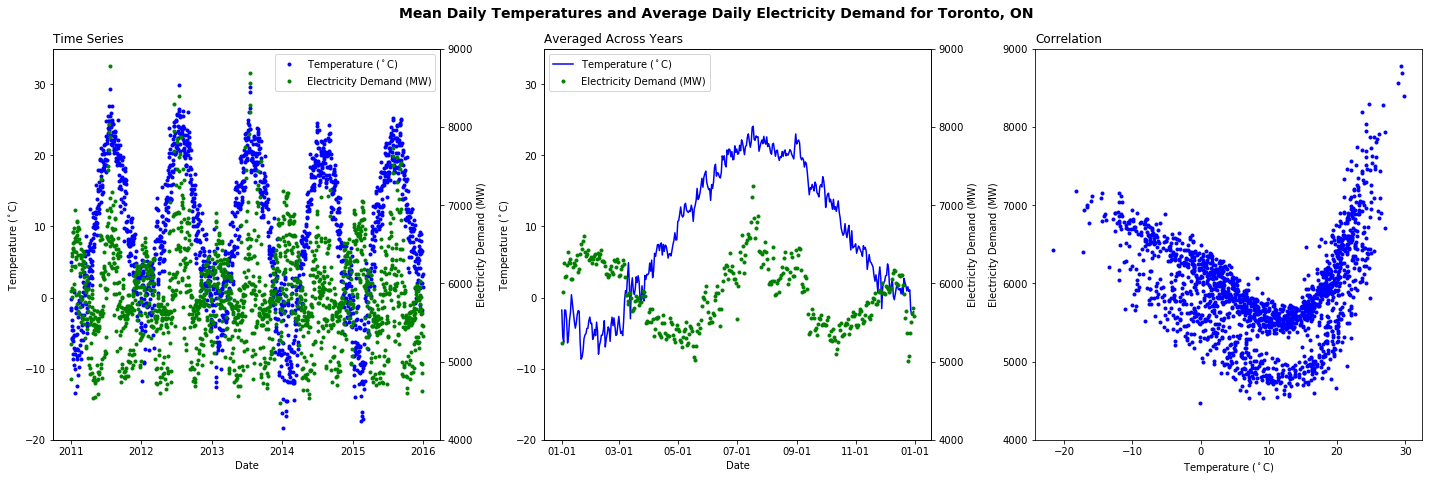

In [30]:
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()